# Part 1

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy
import random

NOTES

-different value distributions d
-different numbers of bidders in each auction (e.g., do the results change between the case of two bidders in the auction and five or ten bidders in the auction?) 
-different number of items for sale in each round (selling 4 items with the truthful 5th price auction)

GOALS

Part 1: 

-Regrets of learning algorithms given optimal revenue for distribution
-How quickly does the algo converge to optimal revenue? (Draw a red line to show optimal revenue with a revenue versus round graph) 
-Show optimal reserve price
-structure in this problem that enables faster learning? (what epsilon value is optimal OR CentricEW algorithm)
-heatmap to get a good idea of different auction scenarios and regrets
-varying learning rates

QUESTIONS

-Theoretical optimal reserve price? How to calculate? 

## Generation Methods

In [86]:
def generate_random_bidlist(num_bidders, num_rounds):
    bid_list = []
    for i in range(num_rounds):
        bidder_bids = [random.random() for i in range(num_bidders)]
        bid_list.append(bidder_bids)
    return bid_list

def generate_quadratic_bidlist(num_bidders, num_rounds):
    bid_list = []
    for i in range(num_rounds):
        bidder_bids = [math.sqrt(random.random()) for i in range(num_bidders)]
        bid_list.append(bidder_bids)
    return bid_list

def generate_exponential_bids(num_bidders, num_rounds):
    bids_uncapped = numpy.random.exponential(scale=1.0, size=num_bidders)
    for index in range(num_bidders):
        if bids_uncapped[index] > 10:
            bids_uncapped[index] = 10
    return bids_uncapped.tolist()

def generate_exponential_bidlist(num_bidders, num_rounds):
    return [generate_exponential_bids(num_bidders, num_rounds) for i in range(num_rounds)]

def generate_linear_discretization(val, epsilon):
    action_list = []
    k = val / epsilon
    
    #calculate number of incremented bids
    num_integ = math.ceil(k)
    
    #value of each linear increment 
    increm = k / num_integ
    
    bid = val
    j = 0
    while bid >= 0:
        action_list.append(bid)
        j = j + 1
        bid = val - (epsilon * (increm * j))
    return action_list

def generate_geometric_discretization(val, epsilon):
    action_list = []
    k = 1/math.e * numpy.log(val)
    bid = val
    j = 0
    while bid >= 0:
        if j == 0: 
            #add both the value bid and the bid of value - 1 according to formula
            action_list.append(bid)
            action_list.append(val - pow((1 + epsilon), j))
        else: 
            if bid not in action_list: 
                action_list.append(bid)
                bid = val - pow((1 + epsilon), j)
            else:
                bid = val - pow((1 + epsilon), j)
        j = j + 1
        
    #add a bid of 0 if not already done so
    if 0 not in action_list:
        action_list.append(0)
        
        
    return action_list

print(generate_linear_discretization(1, .05))

print(generate_geometric_discretization(1, 0.05))

[1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996, 0.1499999999999999, 0.09999999999999998, 0.04999999999999993, 0.0]
[1, 0.0]


## Algorithm Classes

In [87]:
class ExponentialWeights:
    
    def __init__(self, epsilon, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.epsilon = epsilon
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions

    
    def choose_action(self, max_payoff):
        # find weights
        current_weights = [None for i in range(self.num_actions)]
        for action in range(self.num_actions):
            if self.totals_by_round == []:
                V_last = 0
            else:
                V_last = self.totals_by_round[-1][action]
            exp = V_last / max_payoff
            current_weights[action] = pow(1 + self.epsilon, exp)
        # randomly select from actions using weights as probabilities
        selected_action = random.choices(self.actions_list, weights=current_weights, k=1)[0]
        self.choices_by_round.append(selected_action)
        self.weights_vector.append(current_weights)
        #print('current weights', current_weights)
        return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, add payoff choice this round to payoffs matrix
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
                
            
    #NOTE: totals_by_round[-1] at the end of the simulation will help find 'OPT'

In [88]:
class AuctionCentricEW:
    
    def __init__(self, epsilon, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.never_no_payoff = [True for i in range(num_actions)]
        self.actions_list = [i for i in range(num_actions)]
        self.epsilon = epsilon
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.never_no_payoff = [True for i in range(num_actions)]
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions

    
    def choose_action(self, max_payoff):
        # find weights
        current_weights = [None for i in range(self.num_actions)]
        for action in range(self.num_actions):
            if self.totals_by_round == []:
                V_last = 0
            else:
                V_last = self.totals_by_round[-1][action]
            exp = V_last / max_payoff
            current_weights[action] = pow(1 + self.epsilon, exp)
        # randomly select from actions using weights as probabilities
        selected_action = random.choices(self.actions_list, weights=current_weights, k=1)[0]
        
        # if selected action has never been 0, instead pick highest weight 'never_no_payoff'
        if self.never_no_payoff[selected_action]:
            max_weight = current_weights[selected_action]
            max_action = selected_action
            for action in range(self.num_actions):
                if self.never_no_payoff[action] and current_weights[action] > max_weight:
                    max_weight = current_weights[action]
                    max_action = action
            selected_action = max_action
        
        self.choices_by_round.append(selected_action)
        self.weights_vector.append(current_weights)
        #print('current weights', current_weights)
        return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, track payoff this round
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
            
        # update never_been_zero actions
        for index in range(len(payoff_list)):
            payoff = payoff_list[index]
            if payoff == 0 and self.never_no_payoff[index]:
                self.never_no_payoff[index] = False

In [89]:
class FTL:
    
    def __init__(self, num_actions=2):
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions
    
    def choose_action(self, max_payoff):
        # randomly select from actions using highest total payoff so far
        if self.totals_by_round != []:
            selected_action = self.totals_by_round[-1].index(max(self.totals_by_round[-1]))
            self.choices_by_round.append(selected_action)
            return selected_action
        else:
            selected_action = random.randrange(0, self.num_actions)
            return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, add payoff choice this round to payoffs matrix
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
                
            
    #NOTE: totals_by_round[-1] at the end of the simulation will help find 'OPT'

## Auction Simulator

In [90]:
# helpers to find regret of an algorithm
def sum_to_round_i(alg_payoffs, current_round):
    total = 0
    for i in range(current_round):
        total += alg_payoffs[i]
    return total

def individual_regrets(alg_payoffs, round_totals):
    final_payoffs = round_totals[-1]
    opt_action = final_payoffs.index(max(final_payoffs))
    individual_regrets = [0 for i in range(len(alg_payoffs))]
    for round_x in range((len(alg_payoffs))):
        individual_regrets[round_x] = (round_totals[round_x][opt_action] - sum_to_round_i(alg_payoffs, round_x)) / (round_x + 1)
    return individual_regrets

#returns winning bid/revenue 
def find_payoff(r_price, bid_list, num_items=None):
    if num_items == None:
        sorted_bids = sorted(bid_list, reverse=True)
        max_bid = sorted_bids[0]
        second_bid = sorted_bids[1]
        if r_price > second_bid and r_price <= max_bid:
            return r_price
        elif r_price > second_bid and r_price > max_bid:
            return 0
        else:
            return second_bid
    else:
        sorted_bids = sorted(bid_list, reverse=True)
        first_bid = sorted_bids[num_items - 2]
        second_bid = sorted_bids[num_items - 1]
        if r_price > second_bid and r_price <= first_bid:
            return r_price
        elif r_price > second_bid and r_price > first_bid:
            return 0
        else:
            return second_bid

def auction_simulator(alg, bid_lists, num_rounds, max_bid, price_discretization, num_items=None):
    num_actions = len(price_discretization)
    for bid_list in bid_lists:
        # have the algorithm select a bid
        alg_action = alg.choose_action(max_bid)
        alg_price = price_discretization[alg_action]
        
        # calculate payoff list for each reserve price on the discretization
        payoff_list = []
        for reserve_price in price_discretization:
            payoff_list.append(find_payoff(reserve_price, bid_list, num_items))
        alg_payoff = payoff_list[alg_action]
        alg.process_payoff(alg_payoff, payoff_list)
    
    # calculate regrets and payoffs
    alg_regrets = individual_regrets(alg.payoffs_by_round, alg.totals_by_round)
    alg_payoffs = alg.payoffs_by_round
    
    return alg_regrets, alg_payoffs

#bid_lists = [[0, 1], [0, .75], [0, .5], [0, .25]]
#alg = ExponentialWeights(0.0, len(generate_linear_discretization(0, 1, 0.25)))
#alg_regrets, alg_payoffs = auction_simulator(alg, bid_lists, 4, 1, generate_linear_discretization(0, 1, 0.25))
#print(alg_regrets)
#print(alg_payoffs)
#print(alg.weights_vector[-1])
#print(alg.choices_by_round)
#print(alg.totals_by_round)

## Auction Monte Carlo Trials

In [91]:
## Auction Monte Carlo Trials
def auction_trial(alg, auction_list, num_rounds, max_bid, price_discretization, num_items=None):
    alg_avg_regret_per_round = None
    alg_avg_payoff_per_round = None

    for auction in auction_list:
        # find which trial number we are on
        n = auction_list.index(auction)
                    
        # run matchup and find regret lists
        new_alg_regrets, new_alg_payoffs = auction_simulator(alg, auction, num_rounds, max_bid, price_discretization, num_items)
        
        # update average regrets
        if alg_avg_regret_per_round == None:
            alg_avg_regret_per_round = new_alg_regrets
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_regret_per_round[i] = ((n * alg_avg_regret_per_round[i]) + new_alg_regrets[i]) / (n + 1) 
        
        # update average payoffs
        if alg_avg_payoff_per_round == None:
            alg_avg_payoff_per_round = new_alg_payoffs
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_payoff_per_round[i] = ((n * alg_avg_payoff_per_round[i]) + new_alg_payoffs[i]) / (n + 1) 
        
        # reset alg internally stored values
        alg.reset_instance(num_actions=len(price_discretization))
        #print('final weights', alg.weights_vector)
    return alg_avg_regret_per_round, alg_avg_payoff_per_round

#bid_lists = [[0, 1], [0, .75], [0, .5], [0, .25]]
#alg = ExponentialWeights(1.0, len(generate_linear_discretization(0, 1, 0.25)))
#alg_regrets, alg_payoffs = auction_trial(alg, [bid_lists, bid_lists], 4, 1, generate_linear_discretization(0, 1, 0.25))
#print(alg_regrets)
#print(alg_payoffs)

## Visualization of Regrets

In [92]:
def visualize_rounds(alg_regrets, rounds, lr, plot_title, alg_name, trial_type, y_label):
    
    file_name = plot_title + '.png'
    
    x = numpy.array(list(range(0, rounds)))
    y_1 = numpy.array(alg_regrets)
    plt.plot(x, y_1, label='{alg_name}, learning rate = {lr}'.format(alg_name=alg_name, lr = lr), linewidth=1)
    plt.xlabel("Round")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc='best', prop={'size': 7})
    
    plt.savefig(file_name)

    plt.show()


# Trials on Different Bidder Generation Methods, Discretizations, Number of Bidders

0.012960915280638603
0.4259395097340227
avg p1 0.40851724980574755
avg r1 0.02795169081011908
0.01290329626427034
0.4196899242875832
avg p2 0.40823633172621365
avg r2 0.027296644362001934
0.012642580541699292
0.4231235034645915
avg p3 0.4082944088299217
avg r3 0.027259624281244982
0.009638422556051428
0.39868886850598134
avg p4 0.41131161036043973
avg r4 0.020806393152842405
0.0895838398832469
0.3346199402105708
avg p5 0.33200090078457917
avg r5 0.09358615440132413


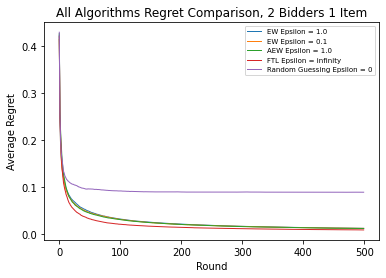

In [93]:
# PARAMETERS
NUM_TRIALS = 1000
NUM_ROUNDS = 500

# 2 bidder random values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('avg p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('avg r1', sum(alg1_regrets) / len(alg1_regrets))

#visualize_rounds(alg1_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial with Epsilon = 0
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('avg p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('avg r2', sum(alg2_regrets) / len(alg2_regrets))

#visualize_rounds(alg2_regrets, NUM_ROUNDS, .5, "Epsilon 0.1 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, .5, "Epsilon 0.1 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial Epsilon = 1, AuctionCentricEW
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = AuctionCentricEW(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('avg p3', sum(alg3_payoffs) / len(alg3_payoffs))
print('avg r3', sum(alg3_regrets) / len(alg3_regrets))

#visualize_rounds(alg3_regrets, NUM_ROUNDS, .5, "AuctionCentricEW Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, .5, "AuctionCentricEW Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial Epsilon = infinity
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = FTL(len(price_discretization))
alg4_regrets, alg4_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg4_regrets[-1])
print(alg4_payoffs[-1])
print('avg p4', sum(alg4_payoffs) / len(alg4_payoffs))
print('avg r4', sum(alg4_regrets) / len(alg4_regrets))

#visualize_rounds(alg4_regrets, NUM_ROUNDS, 0, "FTL on Randomized Auction: Regrets", "FTL", "FTL on Randomized Auction", "Regret per Round")
#visualize_rounds(alg4_payoffs, NUM_ROUNDS, 0, "FTL on Randomized Auction: Payoffs", "FTL", "FTL on Randomized Auction", "Payoff per Round")


# 2 bidder random values auction trial Epsilon = 0
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(0, len(price_discretization))
alg5_regrets, alg5_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg5_regrets[-1])
print(alg5_payoffs[-1])
print('avg p5', sum(alg5_payoffs) / len(alg5_payoffs))
print('avg r5', sum(alg5_regrets) / len(alg5_regrets))

#visualize_rounds(alg5_regrets, NUM_ROUNDS, 0, "Random guessing on Randomized Auction: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg5_payoffs, NUM_ROUNDS, 0, "Random guessing on Randomized Auction: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


file_name = 'All Algorithms Regret Comparison, 2 Bidders 1 Item' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
y_4 = numpy.array(alg4_regrets)
y_5 = numpy.array(alg5_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0'.format(alg_name="EW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 0.1'.format(alg_name="EW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_3, label='AEW Epsilon = 1.0'.format(alg_name="AEW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_4, label='FTL Epsilon = infinity'.format(alg_name="FTL Epsilon = infinity"), linewidth=1)
plt.plot(x_all, y_5, label='Random Guessing Epsilon = 0'.format(alg_name="Random Guessing Epsilon = 0"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('All Algorithms Regret Comparison, 2 Bidders 1 Item')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()


In [94]:
#print(alg_regrets)

### Trials with different numbers of bidders

0.01214210659994524
0.5284878853665955
avg p1 0.5237129068264128
avg r1 0.02617839095161331
0.008814142555207795
0.6739168060048142
avg p2 0.6673390684666664
avg r2 0.021198913815062198
0.003400680962052394
0.9040098177412361
avg p4 0.9036049474316002
avg r4 0.016093610852767982
0.002557950091349545
0.9605935428611636
avg p4 0.9603282853451348
avg r4 0.014601152520941844


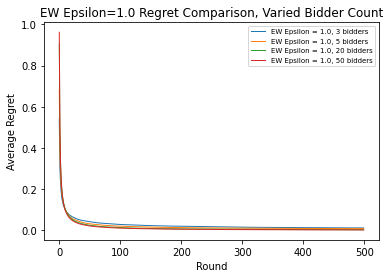

In [95]:
# PARAMETERS
NUM_TRIALS = 1000
NUM_ROUNDS = 500
# 3 bidders EW on random values

num_bidders = 3
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('avg p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('avg r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 3 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 3 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_bidders = 5
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('avg p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('avg r2', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

num_bidders = 20
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('avg p4', sum(alg3_payoffs) / len(alg3_payoffs))
print('avg r4', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_bidders = 50
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg4_regrets, alg4_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg4_regrets[-1])
print(alg4_payoffs[-1])
print('avg p4', sum(alg4_payoffs) / len(alg4_payoffs))
print('avg r4', sum(alg4_regrets) / len(alg4_regrets))
#visualize_rounds(alg4_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg4_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


file_name = 'EW Epsilon=1.0 Regret Comparison, Varied Bidder Count' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
y_4 = numpy.array(alg4_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0, 3 bidders'.format(alg_name="3 bidders"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 1.0, 5 bidders'.format(alg_name="5 bidders"), linewidth=1)
plt.plot(x_all, y_3, label='EW Epsilon = 1.0, 20 bidders'.format(alg_name="20 bidders"), linewidth=1)
plt.plot(x_all, y_4, label='EW Epsilon = 1.0, 50 bidders'.format(alg_name="50 bidders"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('EW Epsilon=1.0 Regret Comparison, Varied Bidder Count')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()


### Trials with different numbers of auctioned items

0.008304402155865781
0.5004435552648464
avg p1 0.49924882278138744
avg r1 0.021577365124274016
0.00830015494898584
0.4961259756275126
avg p2 0.4995550114848366
avg r2 0.02166557438068829
0.009583902031500507
0.19500124206184058
avg p3 0.18303110359927158
avg r3 0.022727398751489353


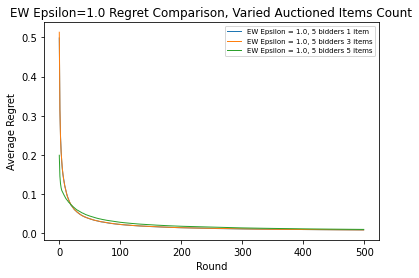

In [96]:
num_bidders = 5
num_items = 3
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization, num_items)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('avg p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('avg r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 1 Items: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 1 Items: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_bidders = 5
num_items = 3
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization, num_items)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('avg p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('avg r2', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 3 Items: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 3 Items: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

num_bidders = 5
num_items = 5
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization, num_items)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('avg p3', sum(alg3_payoffs) / len(alg3_payoffs))
print('avg r3', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 5 Items: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 5 Items: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

file_name = 'EW Epsilon=1.0 Regret Comparison, Varied Auctioned Items Count' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0, 5 bidders 1 item'.format(alg_name="1 item"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 1.0, 5 bidders 3 items'.format(alg_name="3 items"), linewidth=1)
plt.plot(x_all, y_3, label='EW Epsilon = 1.0, 5 bidders 5 items'.format(alg_name="5 items"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('EW Epsilon=1.0 Regret Comparison, Varied Auctioned Items Count')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()


## Heatmap of different variations of bidders and items for sale

In [97]:

num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")


plt.figure( figsize = (15 ,5) )
s = sns.heatmap(data, xticklabels = row_header, yticklabels = col_header, annot = True, cmap =" YlGnBu ", fmt =’.3f’)
plt.xlabel(’k’, fontsize = 18 , cbar_kws ={ ’label ’: ’Average Regret ’})plt . ylabel (’n’, fontsize = 18)
plt.title( title , fontsize = 18)
plt.show()

SyntaxError: invalid character '’' (U+2019) (654777405.py, line 18)

### Trials on different distributions

0.012640616718377668
0.41915400753764653
p1 0.40750339752543685
r1 0.027302794369643054
0.012777467780157543
0.5915676174479857
p2 0.5767818056443277
r2 0.0286614468893387
0.015872296567661624
0.6935549906245301
p3 0.6599617144554704
r 0.03320057989934148


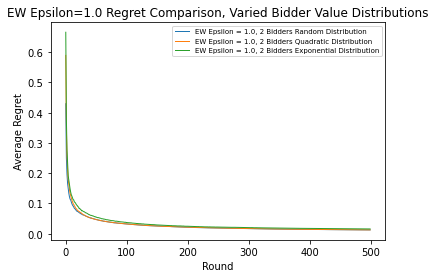

In [98]:
# 2 bidder random values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder quadratic values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_quadratic_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('r2', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder exponential values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_exponential_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('p3', sum(alg3_payoffs) / len(alg3_payoffs))
print('r', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")


file_name = 'EW Epsilon=1.0 Regret Comparison, Varied Bidder Value Distributions' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0, 2 Bidders Random Distribution'.format(alg_name="2 Random Bidders"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 1.0, 2 Bidders Quadratic Distribution'.format(alg_name="2 Quadratic Bidders"), linewidth=1)
plt.plot(x_all, y_3, label='EW Epsilon = 1.0, 2 Bidders Exponential Distribution'.format(alg_name="2 Exponential Bidders"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('EW Epsilon=1.0 Regret Comparison, Varied Bidder Value Distributions')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()


# Part 2 Selling Introductions

### Part 2 Simulator

In [99]:
def find_intro_payoff(price, employee_list, employer_list):
    total_payoff = 0
    for index in range(len(employee_list)):
        employee_val = employee_list[index]
        employer_val = employer_list[index]
        if employer_val + employee_val >= price:
            total_payoff += price
        else:
            total_payoff += 0
    return total_payoff

def introduction_auction_simulator(alg, employee_lists, employer_lists, num_rounds, max_bid, price_discretization, num_items=None):
    num_actions = len(price_discretization)
    for index in range(len(employee_lists)):
        employee_list = employee_lists[index]
        employer_list = employer_lists[index]
        # have the algorithm select a bid
        alg_action = alg.choose_action(max_bid)
        alg_price = price_discretization[alg_action]
        
        # calculate payoff list for each reserve price on the discretization
        payoff_list = []
        for introduction_price in price_discretization:
            payoff_list.append(find_intro_payoff(introduction_price, employee_list, employer_list))
        alg_payoff = payoff_list[alg_action]
        alg.process_payoff(alg_payoff, payoff_list)
    
    # calculate regrets and payoffs
    alg_regrets = individual_regrets(alg.payoffs_by_round, alg.totals_by_round)
    alg_payoffs = alg.payoffs_by_round
    
    return alg_regrets, alg_payoffs


### Introduction Monte Carlo Trials

In [100]:
## Auction Monte Carlo Trials
def introduction_auction_trial(alg, auction_list, num_rounds, max_bid, price_discretization, num_items=None):
    alg_avg_regret_per_round = None
    alg_avg_payoff_per_round = None

    for auction in auction_list:
        # find which trial number we are on
        n = auction_list.index(auction)
        
        # get employee and employer meet value lists
        employee_lists = auction[0]
        employer_lists = auction[1]
                    
        # run matchup and find regret lists
        new_alg_regrets, new_alg_payoffs = introduction_auction_simulator(alg, employee_lists, employer_lists, num_rounds, max_bid, price_discretization, num_items)
        
        # update average regrets
        if alg_avg_regret_per_round == None:
            alg_avg_regret_per_round = new_alg_regrets
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_regret_per_round[i] = ((n * alg_avg_regret_per_round[i]) + new_alg_regrets[i]) / (n + 1) 
        
        # update average payoffs
        if alg_avg_payoff_per_round == None:
            alg_avg_payoff_per_round = new_alg_payoffs
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_payoff_per_round[i] = ((n * alg_avg_payoff_per_round[i]) + new_alg_payoffs[i]) / (n + 1) 
        
        # reset alg internally stored values
        alg.reset_instance(num_actions=len(price_discretization))
        #print('final weights', alg.weights_vector)
    return alg_avg_regret_per_round, alg_avg_payoff_per_round

# Introduction Selling Tests

### Different Algorithms

0.016452160000000184
0.5490799999999993
avg p1 0.5354323599999998
avg r1 0.03479470868404145
0.038782040000000594
0.5300800000000011
avg p1 0.5122707199999997
avg r1 0.0749971803842861
0.013166060000000113
0.5300199999999992
avg p1 0.5390095200000001
avg r1 0.024877099150937217
0.17682042000000037
0.3695099999999998
avg p1 0.37401256000000005
avg r1 0.18196385756282413
0.013273899999999996
0.5520999999999995
avg p1 0.5376827999999996
avg r1 0.0252020566299836


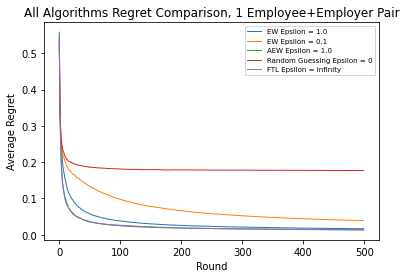

In [101]:
# PARAMETERS
NUM_TRIALS = 1000
NUM_ROUNDS = 500
# 1 employees+employer pairs EW Epsilon = 1.0 on random values
num_pairs = 1

auction_list = []
min_payoff, max_payoff = 0, 1
# perform 1000 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('avg p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('avg r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 0, "EW on Introduction Offers 1 Employee+Employer Pair: Regrets", "EW Epsilon=1.0", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 0, "EW on Introduction Offers 1 Employee+Employer Pair: Payoffs", "EW Epsilon=1.0", "Randomized Auction", "Payoff per Round")

# 1 employees+employer pairs EW Epsilon = 1.0 on random values
num_pairs = 1

auction_list = []
min_payoff, max_payoff = 0, 1
# perform 1000 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(0.1, len(price_discretization))
alg2_regrets, alg2_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('avg p1', sum(alg2_payoffs) / len(alg2_payoffs))
print('avg r1', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 0, "EW on Introduction Offers 1 Employee+Employer Pair: Regrets", "EW Epsilon=0.1", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 0, "EW on Introduction Offers 1 Employee+Employer Pair: Payoffs", "EW Epsilon=0.1", "Randomized Auction", "Payoff per Round")

# 1 employees+employer pairs FTL on random values
num_pairs = 1

auction_list = []
min_payoff, max_payoff = 0, 1
# perform 1000 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = FTL(len(price_discretization))
alg3_regrets, alg3_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('avg p1', sum(alg3_payoffs) / len(alg3_payoffs))
print('avg r1', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 0, "FTL on Introduction Offers 1 Employee+Employer Pair: Regrets", "FTL", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 0, "FTL on Introduction Offers 1 Employee+Employer Pair: Payoffs", "FTL", "Randomized Auction", "Payoff per Round")

# 1 employees+employer pairs Random Guessing on random values
num_pairs = 1

auction_list = []
min_payoff, max_payoff = 0, 1
# perform 1000 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(0.0, len(price_discretization))
alg4_regrets, alg4_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg4_regrets[-1])
print(alg4_payoffs[-1])
print('avg p1', sum(alg4_payoffs) / len(alg4_payoffs))
print('avg r1', sum(alg4_regrets) / len(alg4_regrets))
#visualize_rounds(alg4_regrets, NUM_ROUNDS, 0, "RG on Introduction Offers 1 Employee+Employer Pair: Regrets", "RG", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg4_payoffs, NUM_ROUNDS, 0, "RG on Introduction Offers 1 Employee+Employer Pair: Payoffs", "RG", "Randomized Auction", "Payoff per Round")

auction_list = []
min_payoff, max_payoff = 0, 1
# perform 1000 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = FTL(len(price_discretization))
alg5_regrets, alg5_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg5_regrets[-1])
print(alg5_payoffs[-1])
print('avg p1', sum(alg5_payoffs) / len(alg5_payoffs))
print('avg r1', sum(alg5_regrets) / len(alg5_regrets))
#visualize_rounds(alg4_regrets, NUM_ROUNDS, 0, "RG on Introduction Offers 1 Employee+Employer Pair: Regrets", "RG", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg4_payoffs, NUM_ROUNDS, 0, "RG on Introduction Offers 1 Employee+Employer Pair: Payoffs", "RG", "Randomized Auction", "Payoff per Round")



file_name = 'All Algorithms Regret Comparison, 1 Employee+Employer Pair' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
y_4 = numpy.array(alg4_regrets)
y_5 = numpy.array(alg5_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0'.format(alg_name="EW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 0.1'.format(alg_name="EW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_3, label='AEW Epsilon = 1.0'.format(alg_name="AEW Epsilon = 1.0"), linewidth=1)
plt.plot(x_all, y_4, label='Random Guessing Epsilon = 0'.format(alg_name="Random Guessing Epsilon = 0"), linewidth=1)
plt.plot(x_all, y_5, label='FTL Epsilon = infinity'.format(alg_name="FTL Epsilon = infinity"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('All Algorithms Regret Comparison, 1 Employee+Employer Pair')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

### Different numbers of employee+employer pairs

0.0829766000000001
1.6413399999999978
avg p1 1.5950150999999995
avg r1 0.19664895280842573
0.10802840000000029
2.728249999999992
avg p2 2.6682014999999955
avg r2 0.28319445450076025
0.15969790000000042
5.3905699999999905
avg p3 5.374420899999999
avg r3 0.48419798176495116


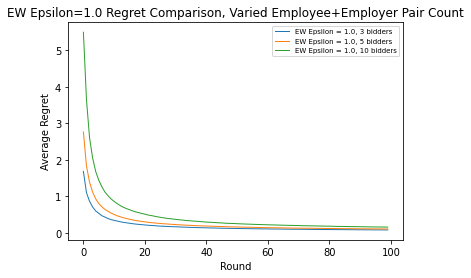

In [102]:
# PARAMETERS
NUM_TRIALS = 1000
NUM_ROUNDS = 100
# 3 bidders EW on random values

num_pairs = 3
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('avg p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('avg r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 0, "EW Introduction Selling, 3 Employee+Employer Pairs: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 0, "EW Introduction Selling, 3 Employee+Employer Pairs: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_pairs = 5
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('avg p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('avg r2', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 0, "EW Introduction Selling, 5 Employee+Employer Pairs: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 0, "EW Introduction Selling, 5 Employee+Employer Pairs: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

num_pairs = 10
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('avg p3', sum(alg3_payoffs) / len(alg3_payoffs))
print('avg r3', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 0, "EW Introduction Selling, 10 Employee+Employer Pairs: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 0, "EW Introduction Selling, 10 Employee+Employer Pairs: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

file_name = 'EW Epsilon=1.0 Regret Comparison, Varied Employee+Employer Pair Count' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0, 3 bidders'.format(alg_name="3 bidders"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 1.0, 5 bidders'.format(alg_name="5 bidders"), linewidth=1)
plt.plot(x_all, y_3, label='EW Epsilon = 1.0, 10 bidders'.format(alg_name="10 bidders"), linewidth=1)

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('EW Epsilon=1.0 Regret Comparison, Varied Employee+Employer Pair Count')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()


### Different Distributions

0.1575859000000003
5.4506999999999906
p1 5.376337299999997
r1 0.4809858413295075
0.18354020000000026
8.335639999999977
p2 8.228302899999996
r2 0.7138477331601151
0.16658390000000037
7.422760000000002
p3 7.2602981999999985
r3 0.6557620960729419
0.16448470000000018
6.3880799999999915
p4 6.259551200000004
r4 0.5496420755172161


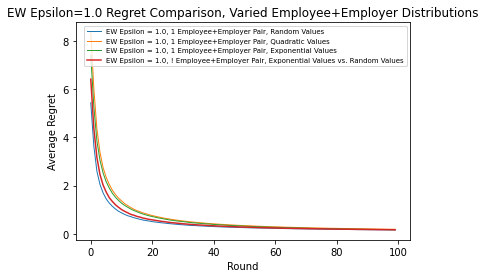

In [103]:
# 2 bidder random values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg1_regrets, alg1_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg1_regrets[-1])
print(alg1_payoffs[-1])
print('p1', sum(alg1_payoffs) / len(alg1_payoffs))
print('r1', sum(alg1_regrets) / len(alg1_regrets))
#visualize_rounds(alg1_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Introduction Selling: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg1_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Introduction Selling: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder quadratic values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_quadratic_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_quadratic_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg2_regrets, alg2_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg2_regrets[-1])
print(alg2_payoffs[-1])
print('p2', sum(alg2_payoffs) / len(alg2_payoffs))
print('r2', sum(alg2_regrets) / len(alg2_regrets))
#visualize_rounds(alg2_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Introduction Selling: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg2_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Introduction Selling: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder exponential values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_exponential_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_exponential_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg3_regrets, alg3_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg3_regrets[-1])
print(alg3_payoffs[-1])
print('p3', sum(alg3_payoffs) / len(alg3_payoffs))
print('r3', sum(alg3_regrets) / len(alg3_regrets))
#visualize_rounds(alg3_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Introduction Selling: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg3_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Introduction Selling: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction = []
    auction.append(generate_random_bidlist(num_pairs, NUM_ROUNDS))
    auction.append(generate_exponential_bidlist(num_pairs, NUM_ROUNDS))
    auction_list.append(auction)
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg4_regrets, alg4_payoffs = introduction_auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg4_regrets[-1])
print(alg4_payoffs[-1])
print('p4', sum(alg4_payoffs) / len(alg4_payoffs))
print('r4', sum(alg4_regrets) / len(alg4_regrets))
#visualize_rounds(alg4_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Employer Values vs. Random Employee Values: Regrets", "EW", "Randomized Auction", "Regret per Round")
#visualize_rounds(alg4_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Employer Values vs. Random Employee Values: Payoffs", "EW", "Randomized Auction", "Payoff per Round")


file_name = 'EW Epsilon=1.0 Regret Comparison, Varied Employee+Employer Distributions' + '.png'
    
x_all = numpy.array(list(range(0, NUM_ROUNDS)))
y_1 = numpy.array(alg1_regrets)
y_2 = numpy.array(alg2_regrets)
y_3 = numpy.array(alg3_regrets)
y_4 = numpy.array(alg4_regrets)
plt.plot(x_all, y_1, label='EW Epsilon = 1.0, 1 Employee+Employer Pair, Random Values'.format(alg_name="Random Employee+Employer"), linewidth=1)
plt.plot(x_all, y_2, label='EW Epsilon = 1.0, 1 Employee+Employer Pair, Quadratic Values'.format(alg_name="Quadratic Employee+Employer"), linewidth=1)
plt.plot(x_all, y_3, label='EW Epsilon = 1.0, 1 Employee+Employer Pair, Exponential Values'.format(alg_name="Exponential Employee+Employer"), linewidth=1)
plt.plot(x_all, y_4, label='EW Epsilon = 1.0, ! Employee+Employer Pair, Exponential Values vs. Random Values'.format(alg_name="Exponential Employer vs Random Employee"))

plt.xlabel("Round")
plt.ylabel("Average Regret") 
plt.title('EW Epsilon=1.0 Regret Comparison, Varied Employee+Employer Distributions')
plt.legend(loc='best', prop={'size': 7})
plt.savefig(file_name)

plt.show()
